# Customer Segmentation  

---

In this project I will explore the characteristics of clients who subscribe to a term deposit and build an AI model which can predict the outcome wheter a client will subscribe or not. Based on this analysis personalized advertisemnt and offers for fitting clients can increase the conversion rates and foster stronger customer loyalty.

# About the Dataset

## Context

Term deposits are a major source of income for a bank. A term deposit is a cash investment held at a financial institution. Your money is invested for an agreed rate of interest over a fixed amount of time, or term. The bank has various outreach plans to sell term deposits to their customers such as email marketing, advertisements, telephonic marketing, and digital marketing.

Telephonic marketing campaigns still remain one of the most effective way to reach out to people. However, they require huge investment as large call centers are hired to actually execute these campaigns. Hence, it is crucial to identify the customers most likely to convert beforehand so that they can be specifically targeted via call.

The data is related to direct marketing campaigns (phone calls) of a Portuguese banking institution. The classification goal is to predict if the client will subscribe to a term deposit (variable y).

## Content

The data is related to the direct marketing campaigns of a Portuguese banking institution. The marketing campaigns were based on phone calls. Often, more than one contact to the same client was required, in order to access if the product (bank term deposit) would be ('yes') or not ('no') subscribed by the customer or not. The data folder contains two datasets:-

banks_train.csv: 45,211 rows and 18 columns ordered by date (from May 2008 to November 2010)
banks_test.csv: 4521 rows and 18 columns with 10% of the examples (4521), randomly selected from train.csv

## Detailed Column Description

**personal data**:  
1 - age (numeric)  
2 - job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student",
"blue-collar","self-employed","retired","technician","services")  
3 - marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)  
4 - education (categorical: "unknown","secondary","primary","tertiary")  

**banking related**
5 - default: has credit in default? (binary: "yes","no")  
6 - balance: average yearly balance, in euros (numeric)  
7 - housing: has housing loan? (binary: "yes","no")  
8 - loan: has personal loan? (binary: "yes","no")  
  
**last contact of the current campaign**:  
9 - contact: contact communication type (categorical: "unknown","telephone","cellular")  
10 - day: last contact day of the month (numeric)  
11 - month: last contact month of year (categorical: "jan", "feb", "mar", …, "nov", "dec")  
12 - duration: last contact duration, in seconds (numeric)  
13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  

**other attributes**:  
14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)  
15 - previous: number of contacts performed before this campaign and for this client (numeric)  
16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")  
  
**Output variable (desired target)**:
17 - y - has the client subscribed a term deposit? (binary: "yes","no")  

Missing Attribute Values: None

## Citation

This dataset is publicly available for research. It has been picked up from the UCI Machine Learning with random sampling and a few additional columns.

Please add this citation if you use this dataset for any further analysis.

S. Moro, P. Cortez and P. Rita. A Data-Driven Approach to Predict the Success of Bank Telemarketing. Decision Support Systems, Elsevier, 62:22-31, June 2014

# 0. Preliminary

In [1]:
# !pip install pandas numpy matplotlib seaborn plotly scipy scikit-learn imbalanced-learn dash kaleido pillow nbformat

In [2]:
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default = 'vscode+png'

from scipy.stats import randint

# ML
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.tree import plot_tree
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from imblearn.ensemble import BalancedRandomForestClassifier

# dash
import dash
from dash import dcc
from dash import html
from dash.dependencies import Input, Output

# png export
import kaleido
from PIL import Image
import os

In [3]:
df_banking_raw = pd.read_csv('../data/banking_train.csv', sep=';')
df_banking = df_banking_raw.copy()

# 1. Data Preperation and EDA

In [4]:
df_banking.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'y'],
      dtype='object')

In [5]:
df_banking

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,unknown,yes
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,unknown,yes
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success,yes
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,unknown,no


In [6]:
numerical = df_banking.select_dtypes(include=[np.number])
categorical = df_banking.select_dtypes(exclude=[np.number])
print(f"dimensions:         {df_banking.shape}")
print(f"numeric columns:    {numerical.shape[1]}")
print(f"categoric columns:  {categorical.shape[1]}")

dimensions:         (45211, 17)
numeric columns:    7
categoric columns:  10


## 1.1. Data Attributes

First we check for NaN Values and dublicates, but as we can see below there are none. Next we will look at each feature individually.

In [7]:
def attributes(df):
    print(f"df_titles dimensions {df.shape}")
    df_attributes = pd.DataFrame(df.dtypes, columns=["dtype"])
    df_attributes["NaN-Values"] = df.isna().sum().values
    df_attributes["% NaN-Values"] = (df.isna().sum().values / df.shape[0] * 100).round(2)
    df_attributes["Dublicates"] = df.duplicated().sum()
    df_attributes["unique"] = df.nunique().values
    return df_attributes
attributes(df_banking)

df_titles dimensions (45211, 17)


,dtype,NaN-Values,% NaN-Values,Dublicates,unique
age,int64,0,0.0,0,77
job,object,0,0.0,0,12
marital,object,0,0.0,0,3
education,object,0,0.0,0,4
default,object,0,0.0,0,2
balance,int64,0,0.0,0,7168
housing,object,0,0.0,0,2
loan,object,0,0.0,0,2
contact,object,0,0.0,0,3
day,int64,0,0.0,0,31


## 1.2 Feature Engineering

In [8]:
df_banking_raw = pd.read_csv('../data/banking_train.csv', sep=';')
df_banking = df_banking_raw.copy()

Feature Engineering:
- RFM-Analysis scores and groups
- age bins based on life stages
- combining jobs
- balance bins
- change name "y" to "deposit"
- make day-month column
- subsitute negative pdays with place holder
- One Hot Encoding


### 1.2.1. Deposit (y)

In [9]:
# rename y to deposit
df_banking = df_banking.rename(columns={'y': 'deposit'})
# binarize deposit
df_banking['deposit'] = df_banking['deposit'].replace({'no': int(0), 'yes': int(1)})
df_banking['deposit'] = df_banking['deposit'].astype(int)

C:\Users\samet\AppData\Local\Temp\ipykernel_17136\1967534879.py:4: FutureWarning:

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`



### 1.2.2. Age

Clients age range 18 - 95 years. Therefore we will categorize the age column in different life stages:

Young Adults (18-30 years):  
This group often begins their professional careers and is therefore an important market for education, technology, fashion, and leisure activities. They are also often renters and buyers of real estate.

Middle Adulthood (30-50 years):  
In this phase, many people have stable careers and incomes. They invest in real estate, cars, family expenses, and retirement savings. This group is also an important market for luxury goods and services.

Late Adulthood (50-65 years):  
People in this age group often prepare for retirement and invest in healthcare, travel, and leisure activities. They are also important consumers of financial services and insurance.

Seniors (65+ years):  
This group has specific needs in terms of health, care, housing, and leisure. They are often retirees and therefore have a fixed income that they spend on various services and products.

In [10]:
# Function to create age_group column (df["newcolumn"] = df["column"].apply(categorize_age))
def categorize_age(age):
    if 18 <= age <= 30:
        return 'young_adults'
    elif 31 <= age <= 50:
        return 'middle_adulthood'
    elif 51 <= age <= 65:
        return 'late_adulthood'
    else:
        return 'seniors'

In [11]:
# Apply the function to create the age_group column
df_banking["age_group"] = df_banking["age"].apply(categorize_age)
# Define the category order
age_group_order = ['young_adults', 'middle_adulthood', 'late_adulthood', 'seniors']
# Convert the age_group column to a categorical type with the specified order
df_banking["age_group"] = pd.Categorical(df_banking["age_group"], categories=age_group_order, ordered=True)

### 1.2.3. Job

We will group the professions as following:
- **Leadership**:
   - Management
   - Admin. (Administrative)
- **Blue-Collar**:
   - Technician
   - Blue-Collar
- **Self-Employment**:
   - Self-Employed
   - Entrepreneur
- **Service**:
   - Services
   - Housemaid
- **Student**
   - Student
- **Retired**:
   - Retired
- **Unemployed**:
   - Unemployed
- **other**:
   - Unknown

In [12]:
# Define a function to categorize jobs
def categorize_job(job):
    """
    This function categorizes jobs into broader categories.

    Parameters
    job (str):          The job title to categorize.
    example:            df_temp['job'] = df_temp['job'].apply(categorize_job)
    
    Returns
    str:                The broader job category.
    """
    if job in ['management', 'admin.']:
        return 'Management'
    elif job in ['technician', 'blue-collar']:
        return 'Blue-Collar'
    elif job in ['self-employed', 'entrepreneur']:
        return 'Self-Employment'
    elif job in ['services', 'housemaid']:
        return 'Service'
    elif job == 'student':
        return 'Student'
    elif job == 'retired':
        return 'Retired'
    elif job == 'unemployed':
        return 'Unemployed'
    else:
        return 'other'

### 1.2.4. Balance

In [13]:
def pcut_balance(df, q=4, labels=None):
    """
    Perform percentile-based binning on the 'balance' column.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the 'balance' column.
    q (int): Number of quantiles. Default is 4 (quartiles).
    labels (list): Labels for the bins. If None, integer labels will be used.

    Returns:
    pd.DataFrame: The DataFrame with an additional 'balance_bin' column.
    Example: df_banking = pcut_balance(df_banking, q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    """
    df = df.copy()
    df['balance_bin'] = pd.qcut(df['balance'], q=q, labels=labels)
    return df

# Example usage:
# df_banking = pcut_balance(df_banking, q=4, labels=['Low', 'Medium', 'High', 'Very High'])

### 1.2.5. Binarize

In [14]:
to_binarize = ['default', 'housing', 'loan']
def binarize_columns(df, columns):
    """
    This function takes a DataFrame and a list of column names, binarizes the specified columns,
    and returns the DataFrame with the binarized columns.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    columns (list): The list of columns to be binarized.
    df_binarized = binarize_columns(df_banking, ['default', 'housing', 'loan', 'y'])

    Returns:
    pd.DataFrame: The DataFrame with binarized columns.
    """
    df = df.copy()
    for column in columns:
        df[column] = df[column].apply(lambda x: int(1) if x == 'yes' else int(0))
    return df

### 1.2.6. Day

In [15]:
def combine_day_month(df, day_col='day', month_col='month', new_col='day_month'):
    """
    This function combines the day and month columns into a new column in the format 'day-month'.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    day_col (str): The name of the day column. Default is 'day'.
    month_col (str): The name of the month column. Default is 'month'.
    new_col (str): The name of the new column to be created. Default is 'day_month'.

    Returns:
    pd.DataFrame: The DataFrame with the new combined column.
    Example: df_banking = combine_day_month(df_banking)
    """
    df[new_col] = df[day_col].astype(str) + '-' + df[month_col].astype(str)
    return df

# Apply the function to the df_banking DataFrame

### 1.2.7. pdyas

In [16]:
# substitute the pdays -1 with 10000
def substitute_pdays(df: pd.DataFrame) -> pd.DataFrame:
    """
    Substitute the value of 'pdays' column in the dataframe.
    
    This function replaces all occurrences of -1 in the 'pdays' column with 10000.
    
    Parameters:
    df (pd.DataFrame): The input dataframe containing a 'pdays' column.
    example: df_temp = substitute_pdays(df_temp)
    Returns:
    pd.DataFrame: The dataframe with substituted 'pdays' values.
    """
    df['pdays'] = df['pdays'].replace(-1, 10000)
    return df

### 1.2.8. OneHotEncoding

In [17]:
def onehot_encode(df, columns):
    """
    This function takes a DataFrame, applies the prepare data for onehotencoding and performs
    onehot encoding.

    Parameters
    df (pd.DataFrame):  The input DataFrame.
    Example          :  df_temp = onehot_encode(df_banking, columns)
    
    Returns
    pd.DataFrame     :  The DataFrame with one-hot encoded columns.
    
    """
    df = df.reset_index(drop=True).copy()
    
    # Initialize the OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)
    encoded_age_group = encoder.fit_transform(df[columns])

    # Create a DataFrame with the encoded columns
    encoded_age_group_df = pd.DataFrame(encoded_age_group.astype(int), columns=encoder.get_feature_names_out(columns))
    df = pd.concat([df, encoded_age_group_df], axis=1)
    
    # Drop the original columns if needed
    df.drop(columns, axis=1, inplace=True)
    return df 

In [18]:
df_banking.columns

Index(['age', 'job', 'marital', 'education', 'default', 'balance', 'housing',
       'loan', 'contact', 'day', 'month', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'deposit', 'age_group'],
      dtype='object')

### 1.2.9. RFM Analysis

RFM (Recency, Frequency, Monetary) analysis is a powerful customer segmentation technique used to identify and evaluate the value of customers based on their purchasing behavior. It involves three key metrics:  
  
Recency: How recently a customer has interacted with the bank (e.g., last transaction date, last contact date).  
Frequency: How often a customer interacts with the bank (e.g., number of transactions, number of contacts).  
Monetary: The monetary value associated with the customer (e.g., total balance, average transaction amount).  
  
By analyzing these metrics, businesses can classify customers into different segments and tailor marketing strategies accordingly to enhance customer retention, loyalty, and profitability.   

- **Champions** are the bank’s top customers. They have frequent transactions and are profitable. Banks must continue to acknowledge and target resources to these customers to keep them happy and engaged with the bank. These are excellent customers to invite to focus groups and to test new products with.  
- **Potential** Loyalists are bank customers with average transaction levels and above-average profitability. These are prime candidates for loyalty programs and cross-selling.  
- **At-risk** customers are bank customers who are profitable and have an average level of engagement but have not recently materially expanded their relationship by opening a new product. This segment is excellent for personalized outreach, invitations, and financial advisory to see where else the bank can add value.  
- **Can’t Lose** Them is the customer segment that used to have high engagement and was profitable but has slowed down. Lower trending frequency scores indicate they might be heading for defection. Bankers can send this segment surveys to understand their position better while also using special promotions to ignite re-engagement.
- **Lost**

In [19]:
# Define the df metrics
def calculate_rfm(df):
    """
    Calculate df (Recency, Frequency, Monetary) metrics for the given DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing customer data.

    Returns:
    pd.DataFrame: The DataFrame with df metrics.
    """
    # Recency: The number of days since the last contact
    df['Recency'] = df['pdays'].apply(lambda x: 0 if x == 10000 else x)
    # Frequency: The number of contacts performed during this campaign and for this client
    df['Frequency'] = df['campaign'] + df['previous']
    # Monetary: The balance of the customer
    df['Monetary'] = df['balance']


    # Assigning R_Score
    df['R_Score'] = 1  # Assign a score of 1 to all Recency values of 0
    non_zero_mask = df['Recency'] != 0    # Create a mask for non-zero Recency values
    df.loc[non_zero_mask, 'R_Score']
    df.loc[non_zero_mask, 'R_Score'] = pd.qcut(df.loc[non_zero_mask, 'Recency'], q=3, labels=[4, 3, 2])  # Apply pd.qcut to non-zero Recency values

    # Assigning F_Score
    df["F_Score"] = pd.qcut(df["Frequency"], q=5, labels=[1, 2, 3, 4], duplicates='drop')

    # Assigning M_Score
    df["M_Score"] = pd.qcut(df["Monetary"], q=4, labels=[1, 2, 3, 4])

    # Combine RFM scores
    df['RFM_Score'] = df['R_Score'].astype(int) + df['F_Score'].astype(int) + df['M_Score'].astype(int)
    
    # Create df segments based on the RFM score
    segment_labels = ['Low-Value', 'Mid-Value', 'High-Value']
    df['Value_Segment'] = pd.qcut(df['RFM_Score'], q=3, labels=segment_labels)
    # Convert the Value Segment column to a categorical type with the specified order
    df['Value_Segment'] = pd.Categorical(df['Value_Segment'], categories=segment_labels, ordered=True)
    
    # Assign df segments based on the df score
    df['Customer_Segments'] = ''
    df.loc[df['RFM_Score'] >= 9, 'Customer_Segments'] = 'Champions'
    df.loc[(df['RFM_Score'] >= 6) & (df['RFM_Score'] < 9), 'Customer_Segments'] = 'Potential Loyalists'
    df.loc[(df['RFM_Score'] >= 5) & (df['RFM_Score'] < 6), 'Customer_Segments'] = 'At Risk Customers'
    df.loc[(df['RFM_Score'] >= 4) & (df['RFM_Score'] < 5), 'Customer_Segments'] = "Can't Lose"
    df.loc[(df['RFM_Score'] >= 3) & (df['RFM_Score'] < 4), 'Customer_Segments'] = "Lost"
    
    df['Customer_Segments'] = pd.Categorical(df['Customer_Segments'], categories=['Champions', 'Potential Loyalists', "Can't Lose", 'At Risk Customers', 'Lost'], ordered=True)
    return df


In [20]:
df_banking['job_new'] = df_banking['job'].apply(categorize_job)
df_banking = pcut_balance(df_banking, q=4, labels=['Low', 'Medium', 'High', 'Very High'])
df_banking = binarize_columns(df_banking, ['default', 'housing', 'loan'])
df_banking = combine_day_month(df_banking)
df_banking = substitute_pdays(df_banking)
df_banking = calculate_rfm(df_banking)

## 1.3. Client Profiling

For the profiling we will look at the information categories seperetly:  
1. Personal information: age, job, marital, education
2. banking: balance, housing, loan
3. current campaign: contact, day, month, duration, campaign
4. previous campaigns: pdays, previous, poutcome

In [21]:
target = ["deposit"]
personal = ["age", "age_group", "marital", "job", "job_new", "education"]
banking = ["default", "housing", "loan", "balance", "balance_bin"]
current = ["contact", "month", "day", "duration", "campaign"]
past = ["pdays", "previous", "poutcome"]

### 1.3.1. Target

In [22]:
# Function to plot the distribution of a feature
def distribution_rel(df, column):
    df[column] = df[column].astype(str)
    df_temp = pd.DataFrame(df[column].value_counts()).reset_index()
    df_temp['percentage'] = (df_temp["count"] / df_temp["count"].sum() * 100).round(2)
    fig = px.bar(df_temp, y='percentage', x=column, color=column, title=f'{column} Distribution', text_auto=True,
           labels={'percentage': f'Percentage of Total [%]<br>100% = {df_temp["count"].sum()} customers'})
    fig.update_layout(showlegend=False,  template="plotly_white",)
    return fig

# Function to plot the distribution of a feature (swithced x and y)
def distribution_cat(df, column):
    df[column] = df[column].astype(str)
    df_temp = pd.DataFrame(df[column].value_counts()).reset_index()
    fig = px.bar(df_temp, y='count', x=column, color=column, title=f'{column} Distribution', text_auto=True,
           labels={'percentage': f'Percentage of Total [%]<br>100% = {df_temp["count"].sum()} customers'})
    fig.update_layout(showlegend=False,  template="plotly_white",)
    return fig

# function to make subplots with distribution
def distribution_2x(df, column):
    fig = make_subplots(1,2, subplot_titles=("Count", "Relative Count [%]"))
    # y distribution
    y_fig = distribution_cat(df, column)
    for trace in y_fig['data']:
        trace["showlegend"] = True
        fig.add_trace(trace, row=1, col=1)

    # relative distribution
    y_rel_fig = distribution_rel(df, column)
    for trace in y_rel_fig['data']:
        trace["showlegend"] = False
        fig.add_trace(trace, row=1, col=2)

    # Adjust bar width
    for trace in fig['data']:
        trace['width'] = 1
    
#     fig.update_layout(
#     height=400, width=600,
#     title={'text': "Distribution of y - Subscribed a term deposit?", 'font': {'size': 20}},
#     showlegend=False, 
#     barmode='group',)
    return fig    

11.7 % have subscribed to a term deposit.

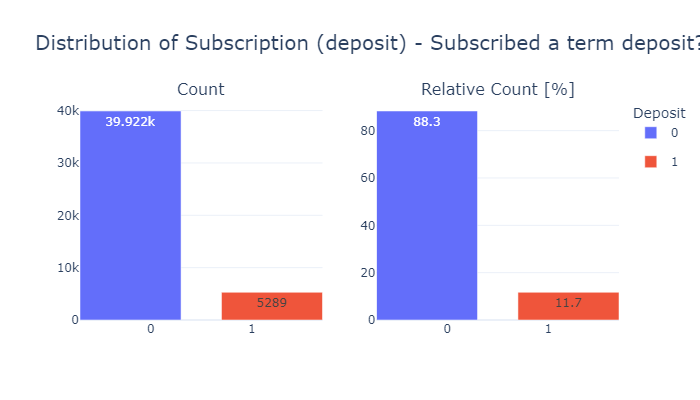

In [23]:
fig = distribution_2x(df_banking, 'deposit')
fig.update_layout(
    height=400, width=700, template="plotly_white",
    title={'text': "Distribution of Subscription (deposit) - Subscribed a term deposit?", 'font': {'size': 20}},
    showlegend=True, legend_title_text='Deposit', 
    barmode='group')

Next we will look at the correlations of deposit, for which we will temporarly change the columns default, housing, loan, and deposit into binary codes

- The outcome correlates medium with duration 
- Housing has a low negative correlation with outcome and the age (older people have less housing loans), but a low positive correlation with the days passed since the last contact (pdays) (housing loan increased since last contact). 
- age has a low correlation with the balance (older people have a higher balance)

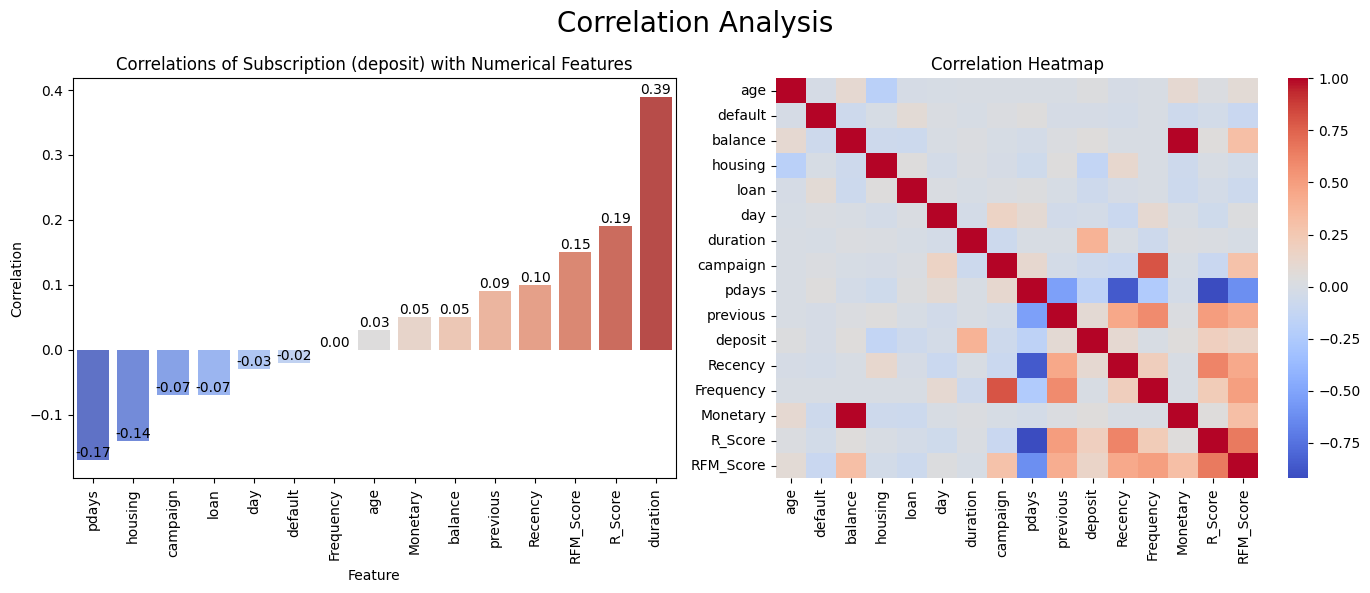

In [24]:
df_temp = df_banking.copy()
# Convert the binary columns to integers
to_binary = ['default', 'housing', 'loan']
target = ["deposit"]
df_temp.deposit = df_temp.deposit.astype(int)
pd.set_option('future.no_silent_downcasting', True)
numerical = df_temp.select_dtypes(include=[np.number])

# Create the bar plot for correlations with Yearly Amount Spent
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
correlation_with_target = numerical.corr()[target].drop(target).sort_values(target).reset_index().rename(columns={"index": "Feature", "deposit": "Correlation"})
ax = sns.barplot(correlation_with_target, x="Feature", y=correlation_with_target["Correlation"].round(2), hue="Feature", palette='coolwarm')
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', xytext=(0, 5), textcoords='offset points')
plt.title('Correlations of Subscription (deposit) with Numerical Features')
plt.ylabel('Correlation')
plt.xticks(rotation=90)

# Create the heatmap
plt.subplot(1, 2, 2)
sns.heatmap(numerical.corr().round(2), cmap="coolwarm")
plt.title('Correlation Heatmap')

plt.suptitle('Correlation Analysis', fontsize=20)
plt.tight_layout()

# Save the plot as a PNG file
# plt.savefig('02_correlation_analysis.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()

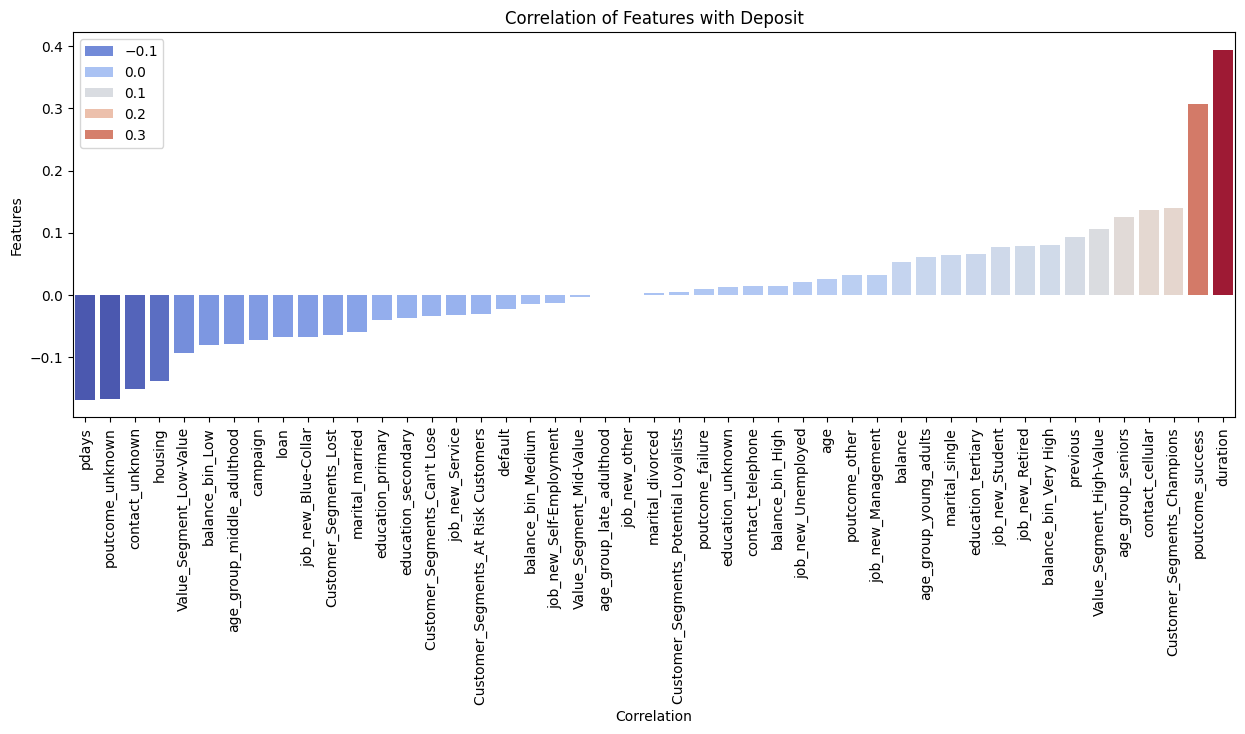

In [25]:
df_temp = df_banking.copy()

to_drop = [ 'job', 'day', 'month', 'day_month', 'Recency', 'Frequency', 'Monetary', 'R_Score', 'F_Score', 'M_Score', 'RFM_Score', ]
to_ohe = ['marital', 'education', 'contact', 'age_group', 'job_new',
       'balance_bin', 'Value_Segment', 'Customer_Segments', 'poutcome']
numeric = ['age', 'default', 'balance', 'housing', 'loan', 'duration', 'previous', 'deposit', 'campaign', 'pdays']

df_temp = onehot_encode(df_temp, to_ohe)

# Drop tcolumns 
df_temp.drop(to_drop, axis=1, inplace=True)
df_temp.deposit = df_temp.deposit.astype(int)

# Extract the correlation of 'deposit' with other features and sort it
corr = df_temp.corr()
corr_deposit = corr['deposit'].drop("deposit").sort_values()

# Plot the sorted correlation values
plt.figure(figsize=(15, 5))
sns.barplot(y=corr_deposit.values, x=corr_deposit.index, hue=corr_deposit.values, palette='coolwarm')
plt.title('Correlation of Features with Deposit')
plt.xlabel('Correlation')
plt.ylabel('Features')
plt.xticks(rotation=90)
plt.show()

### 1.3.2. Personal information

In [26]:
personal = ["age", "age_group", "marital", "job", "job_new", "education"]

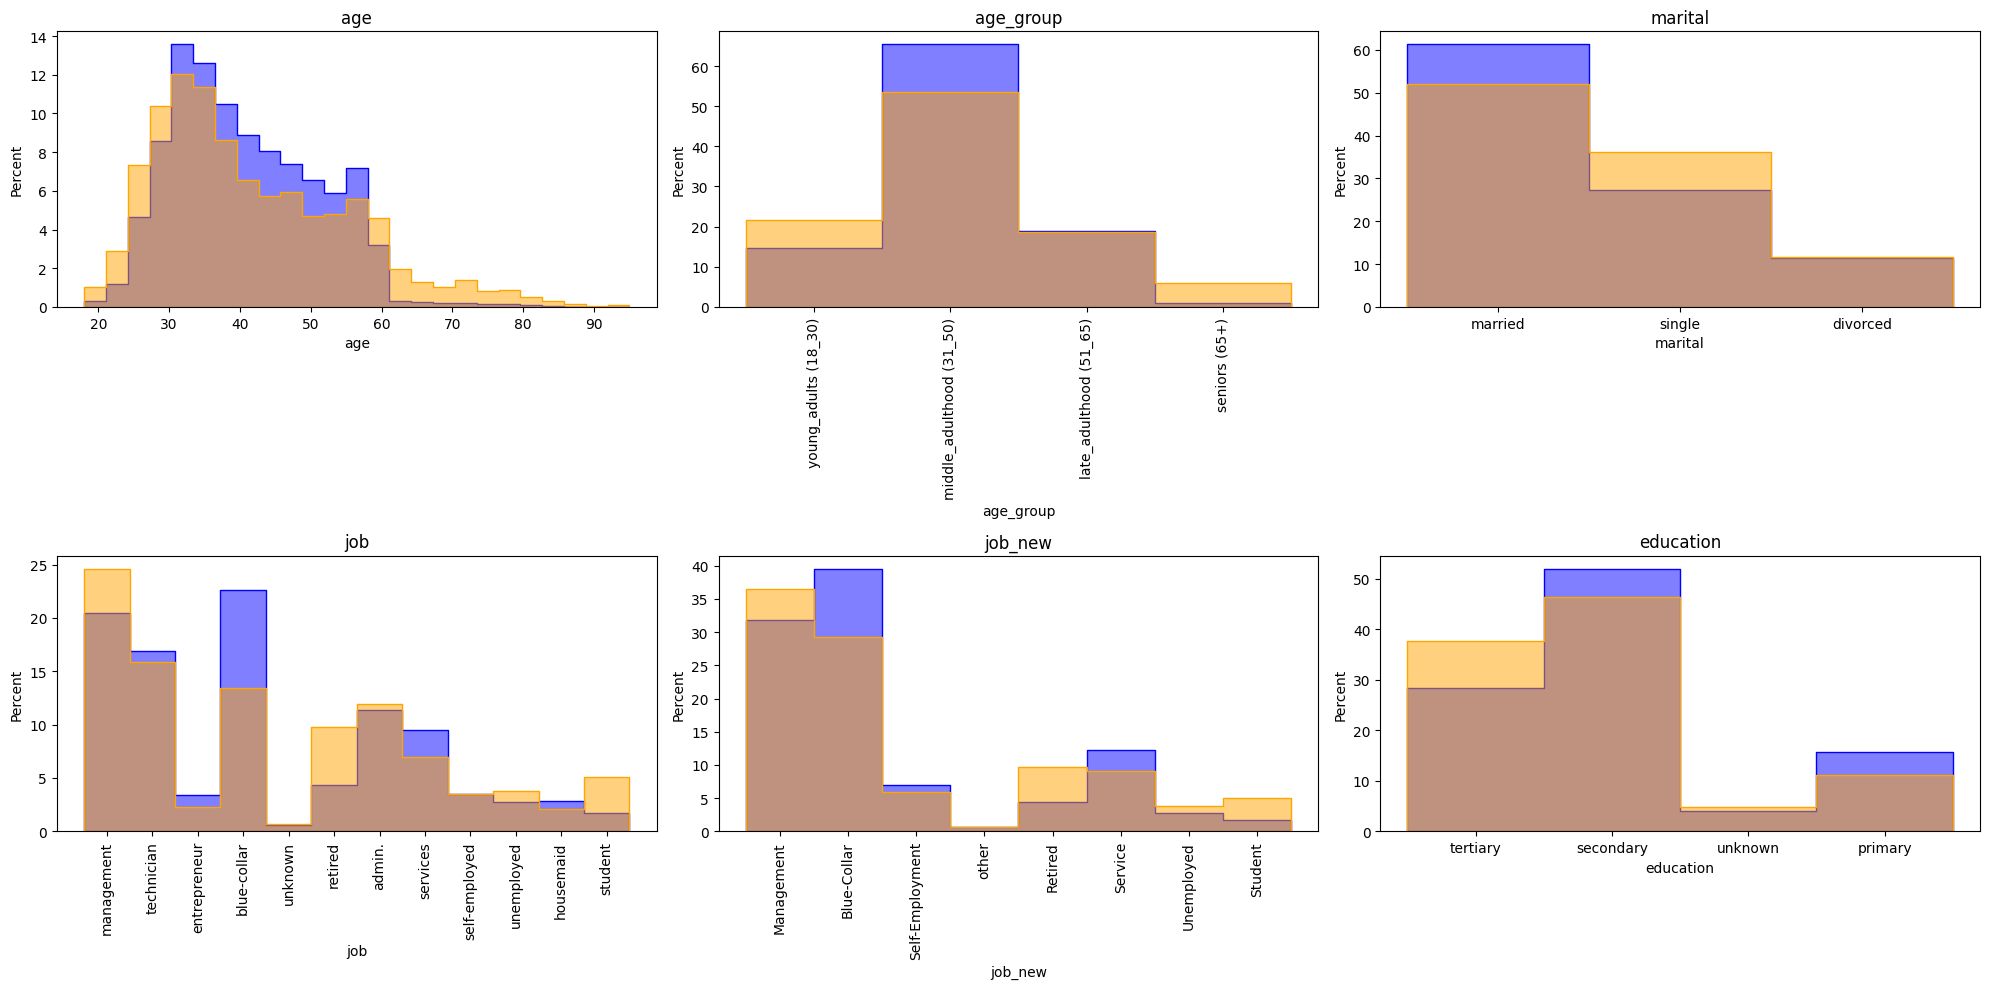

In [27]:
df_temp = df_banking.copy()
df_temp.deposit = df_temp.deposit.astype(int)
df_temp.age_group = df_temp.age_group.map({'young_adults': 'young_adults (18_30)',
                                           'middle_adulthood': 'middle_adulthood (31_50)',
                                           'late_adulthood': 'late_adulthood (51_65)',
                                           'seniors': 'seniors (65+)'})
# Plot the histogram with absolute percentage distribution
deposit_0 = df_temp[df_temp['deposit'] == 0]
deposit_1 = df_temp[df_temp['deposit'] == 1]
# Create subplots with 2 rows and 3 columns (since there are 6 personal features)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
axes = axes.flatten()

# Iterate over personal columns to plot histograms
for i, column in enumerate(personal):
    # Plot histogram for deposit_0 with percentage distribution
    sns.histplot(deposit_0[column], bins=25, ax=axes[i], color='blue', label='no', kde=False, stat='percent', element='step', alpha=0.5)
    # Plot histogram for deposit_1 with percentage distribution
    sns.histplot(deposit_1[column], bins=25, ax=axes[i], color='orange', label='yes', kde=False, stat='percent', element='step', alpha=0.5)
    
    # Set title for each subplot
    axes[i].set_title(column)
    if column in ['job', 'job_new', "age_group"]:
        axes[i].tick_params(axis='x', rotation=90)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Save the plot as a PNG file (commented out)
# plt.savefig('0_distribution_of_features.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
# Show the plot
plt.tight_layout()
plt.show()


Perfect client relative:
- Age: young adult (20-30), seniors (65+)
- Marital: single
- Job: management, retired, student
- Education: tertiary 
  
Most subscribing clients:
- Age: middle adulthood (31-50)
- Marital: married
- Job: Management, Blue-Collar
- Education: secondary


### 1.3.3. Banking

In [28]:
banking = ["default", "housing", "loan", "balance", "balance_bin"]



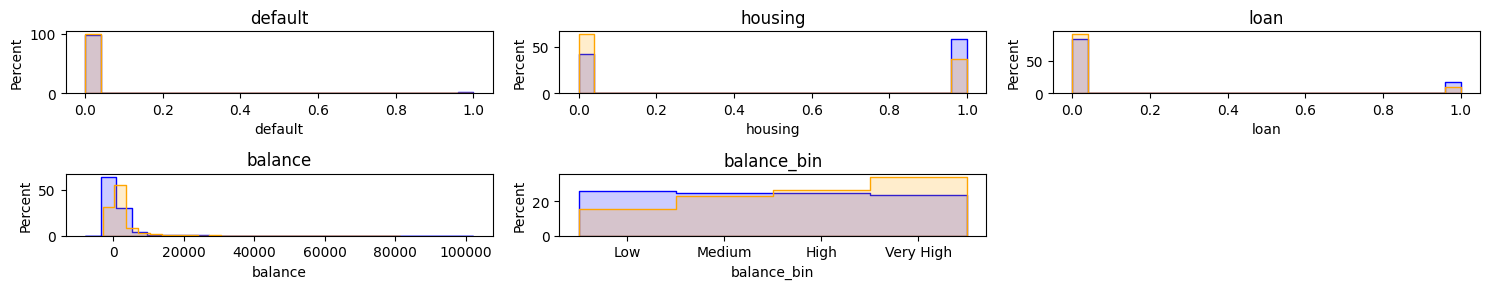

In [29]:
df_temp = df_banking.copy()
df_temp.deposit = df_temp.deposit.astype(int)
deposit_0 = df_temp[df_temp['deposit'] == 0]
deposit_1 = df_temp[df_temp['deposit'] == 1]
# Plot the histogram with absolute percentage distribution

# Create subplots with 2 rows and 3 columns (since there are 6 personal features)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 3))
axes = axes.flatten()

# Iterate over personal columns to plot histograms
for i, column in enumerate(banking):
    # Plot histogram for deposit_0 with percentage distribution
    sns.histplot(deposit_0[column], bins=25, ax=axes[i], color='blue', label='no', kde=False, stat='percent', element='step', alpha=0.2)
    # Plot histogram for deposit_1 with percentage distribution
    sns.histplot(deposit_1[column], bins=25, ax=axes[i], color='orange', label='yes', kde=False, stat='percent', element='step', alpha=0.2)
    
    # Set title for each subplot
    axes[i].set_title(column)
    if column in ['job', 'job_new', "age_group"]:
        axes[i].tick_params(axis='x', rotation=90)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Save the plot as a PNG file (commented out)
# plt.savefig('0_distribution_of_features.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
# Show the plot
plt.tight_layout()
plt.show()


Perfect client relative:
- higher balance
- no default, housing or loan

### 1.3.4. Current campaign

In [30]:
current = ["contact", "month", "day", "duration", "campaign"]



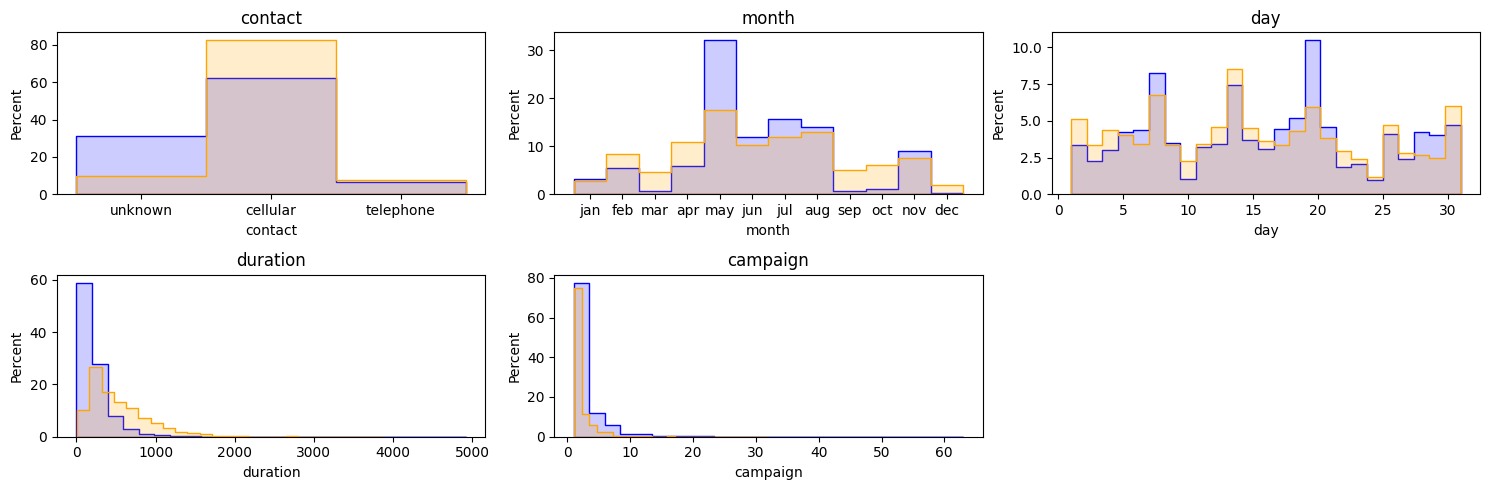

In [31]:
df_temp = df_banking.copy()
df_temp.deposit = df_temp.deposit.astype(int)
category_order = ["jan", "feb", "mar", "apr", "may", "jun", "jul", "aug", "sep", "oct", "nov", "dec"]
df_temp['month'] = pd.Categorical(df_temp['month'], categories=category_order, ordered=True)
deposit_0 = df_temp[df_temp['deposit'] == 0]
deposit_1 = df_temp[df_temp['deposit'] == 1]
# Plot the histogram with absolute percentage distribution

# Create subplots with 2 rows and 3 columns (since there are 6 personal features)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 5))
axes = axes.flatten()

# Iterate over personal columns to plot histograms
for i, column in enumerate(current):
    # Plot histogram for deposit_0 with percentage distribution
    sns.histplot(deposit_0[column], bins=25, ax=axes[i], color='blue', label='no', kde=False, stat='percent', element='step', alpha=0.2)
    # Plot histogram for deposit_1 with percentage distribution
    sns.histplot(deposit_1[column], bins=25, ax=axes[i], color='orange', label='yes', kde=False, stat='percent', element='step', alpha=0.2)
    
    # Set title for each subplot
    axes[i].set_title(column)
    if column in ['job', 'job_new', "age_group"]:
        axes[i].tick_params(axis='x', rotation=90)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Save the plot as a PNG file (commented out)
# plt.savefig('0_distribution_of_features.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
# Show the plot
plt.tight_layout()
plt.show()


Perfect client:
- Contact: cellular phone
- Months: Summer
- Duration: The longer the better
- Campaign: Less contacts

### 1.3.5. Past Campaign

In [32]:
past = ["pdays", "previous", "poutcome"]


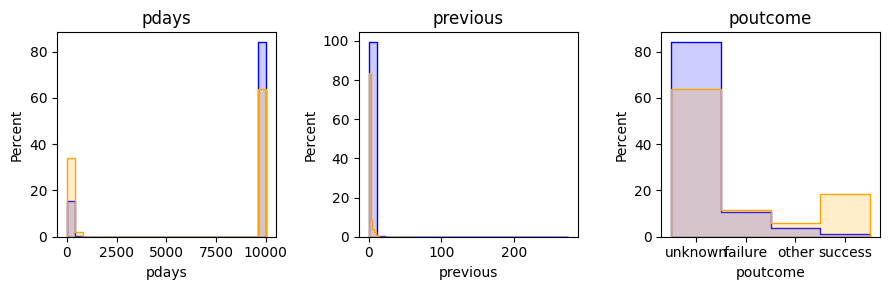

In [33]:
df_temp = df_banking.copy()
df_temp.deposit = df_temp.deposit.astype(int)
deposit_0 = df_temp[df_temp['deposit'] == 0]
deposit_1 = df_temp[df_temp['deposit'] == 1]
# Plot the histogram with absolute percentage distribution

# Create subplots with 2 rows and 3 columns (since there are 6 personal features)
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(9, 3))
axes = axes.flatten()

# Iterate over personal columns to plot histograms
for i, column in enumerate(past):
    # Plot histogram for deposit_0 with percentage distribution
    sns.histplot(deposit_0[column], bins=25, ax=axes[i], color='blue', label='no', kde=False, stat='percent', element='step', alpha=0.2)
    # Plot histogram for deposit_1 with percentage distribution
    sns.histplot(deposit_1[column], bins=25, ax=axes[i], color='orange', label='yes', kde=False, stat='percent', element='step', alpha=0.2)
    
    # Set title for each subplot
    axes[i].set_title(column)
    if column in ['job', 'job_new', "age_group"]:
        axes[i].tick_params(axis='x', rotation=90)

# Remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# Save the plot as a PNG file (commented out)
# plt.savefig('0_distribution_of_features.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
# Show the plot
plt.tight_layout()
plt.show()


Perfect Client:
- pdays: more passing days
- preivous: was contacted for previous campaing
- poutcome: success but also unknown

### 1.3.6. Summary

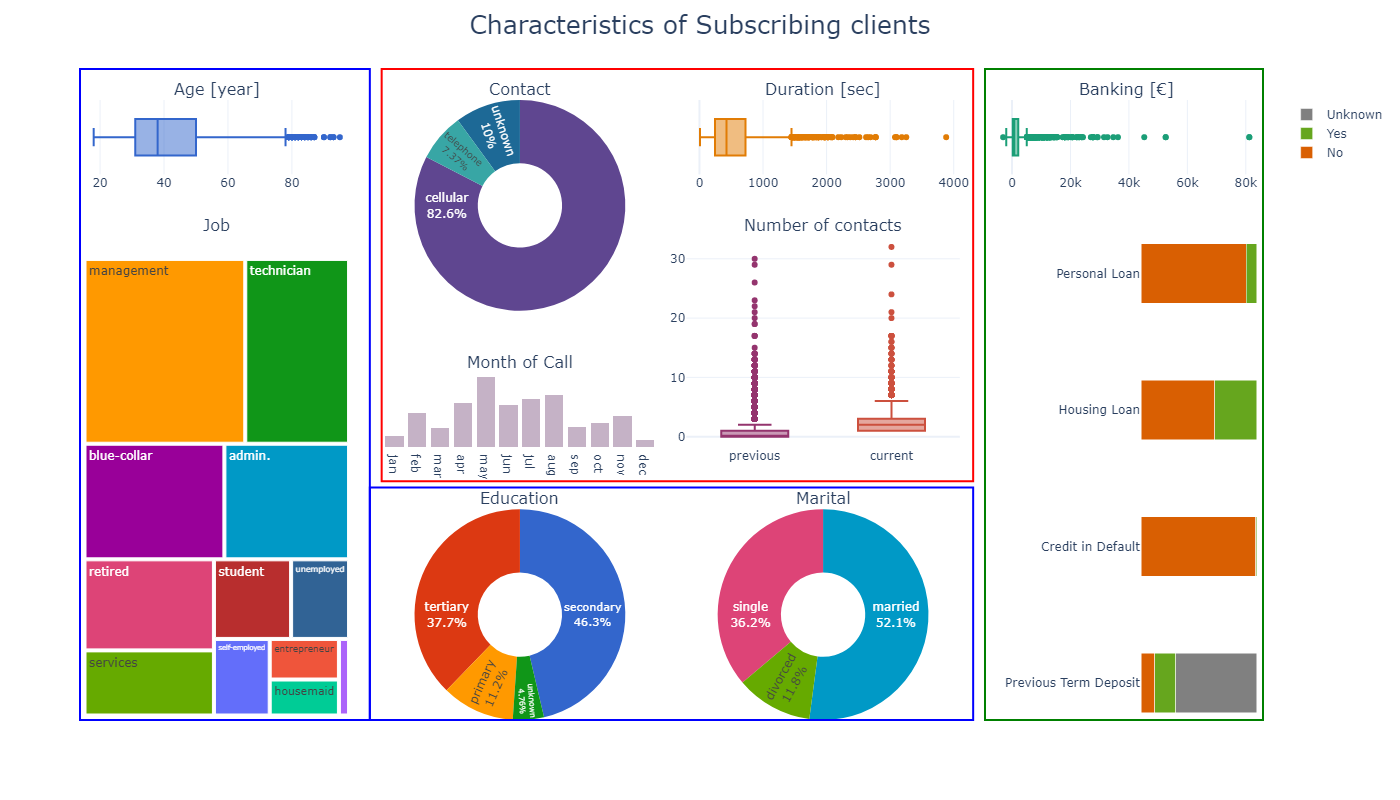

In [87]:
df_temp = df_banking.copy()
df_temp.poutcome = df_temp.poutcome.replace({'unknown': 'Unknown', 'failure': 'Failure', 'success': 'Success', "other": "Unknown"})
df_temp.month = pd.Categorical(df_temp.month, categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], ordered=True) 
df_temp = df_temp[df_temp['deposit'] == "1"]


# Create a 3x5 subplot layout with specified spans
fig = make_subplots(
    rows=5, cols=8,
    specs=[
        [{'rowspan': 1, 'colspan': 2}, None, {"type": "domain", 'rowspan': 2, 'colspan': 2}, None, {'rowspan': 1, 'colspan': 2}, None, {'rowspan': 1, 'colspan': 2}, None],
        [{"type": "domain", 'rowspan': 4, 'colspan': 2}, None, None, None, {'rowspan': 2, 'colspan': 2}, None, None, {'rowspan': 1, 'colspan': 1}],
        [None, None, {'rowspan': 1, 'colspan': 2}, None, None, None, None, {'rowspan': 1, 'colspan': 1}],
        [None, None, {"type": "domain", 'rowspan': 2, 'colspan': 2}, None, {"type": "domain", 'rowspan': 2, 'colspan': 2}, None, None, {'rowspan': 1, 'colspan': 1}],
        [None, None, None, None, None, None, None, {'rowspan': 1, 'colspan': 1}],
    ],
    subplot_titles=["Age [year]", "Contact", "Duration [sec]", "Banking [€]", "Job", "Number of contacts", "", "Month of Call", "", "Education", "Marital", "", ""]
)

# Add traces to the subplots based on the specs

# Histogram
fig.add_trace(go.Histogram(x=df_temp.month.sort_values(), name="", showlegend=False, opacity=0.4, marker_color=px.colors.qualitative.Prism[9]), 3, 3)  # month

# Pie
fig.add_trace(go.Pie(labels=df_temp['contact'].value_counts().index, values=df_temp['contact'].value_counts().values, showlegend=False,
                     hole=.4, textinfo='label+percent', textposition='inside', insidetextorientation='radial',
                     marker=dict(colors=px.colors.qualitative.Prism)), 1, 3)                                                             # contact
fig.add_trace(go.Pie(labels=df_temp['education'].value_counts().index, values=df_temp['education'].value_counts().values, showlegend=False,
                     hole=.4, textinfo='label+percent', textposition='inside', insidetextorientation='radial',
                     marker=dict(colors=px.colors.qualitative.G10)), 4, 3)                                                                 # education
fig.add_trace(go.Pie(labels=df_temp['marital'].value_counts().index, values=df_temp['marital'].value_counts().values, showlegend=False,
                     hole=.4, textinfo='label+percent', textposition='inside', insidetextorientation='radial',
                     marker=dict(colors=px.colors.qualitative.G10[5:])), 4, 5)                                                                  # marital   

# Box
fig.add_trace(go.Box(x=df_temp['age'], name='', showlegend=False, marker_color=px.colors.qualitative.G10[0] ), 1, 1)  # age
fig.add_trace(go.Box(x=df_temp['duration'], name='', showlegend=False, marker_color=px.colors.qualitative.Prism[6]), 1, 5)  # duration
fig.add_trace(go.Box(y=df_temp[(df_temp['previous'] < 40)]["previous"], name='previous', showlegend=False, marker_color=px.colors.qualitative.Prism[8]), 2, 5)  # previous
fig.add_trace(go.Box(y=df_temp['campaign'], name='current', showlegend=False, marker_color=px.colors.qualitative.Prism[7]), 2, 5)  # campaign
fig.add_trace(go.Box(x=df_temp['balance'], name='', showlegend=False, marker_color=px.colors.qualitative.Dark2[0]), 1, 7)  # balance

# Bar
# loan
fig.add_trace(go.Bar(x=df_temp[df_temp['loan'] == 0]["loan"].value_counts().values, y=["Personal Loan"],
                     name='No', orientation='h', marker_color=px.colors.qualitative.Dark2[1], showlegend=False), 2, 8)
fig.add_trace(go.Bar(x=df_temp[df_temp['loan'] == 1]["loan"].value_counts().values, y=["Personal Loan"],
                     name='Yes', orientation='h', marker_color=px.colors.qualitative.Dark2[4], showlegend=False), 2, 8)
# housing
fig.add_trace(go.Bar(x=df_temp[df_temp['housing'] == 0]["housing"].value_counts().values, y=["Housing Loan"], orientation='h',
                     name='No', marker_color=px.colors.qualitative.Dark2[1], showlegend=False), 3, 8)
fig.add_trace(go.Bar(x=df_temp[df_temp['housing'] == 1]["housing"].value_counts().values, y=["Housing Loan"], orientation='h',
                     name='Yes', marker_color=px.colors.qualitative.Dark2[4], showlegend=False), 3, 8) 
# default
fig.add_trace(go.Bar(x=df_temp[df_temp['default'] == 0]["default"].value_counts().values, y=["Credit in Default"], orientation='h',
                     name='No', marker_color=px.colors.qualitative.Dark2[1], showlegend=False), 4, 8)
fig.add_trace(go.Bar(x=df_temp[df_temp['default'] == 1]["default"].value_counts().values, y=["Credit in Default"], orientation='h',
                     name='Yes', marker_color=px.colors.qualitative.Dark2[4], showlegend=False), 4, 8) 
# poutcome
fig.add_trace(go.Bar(x=df_temp[df_temp['poutcome'] == "Failure"]["poutcome"].value_counts().values, y=["Previous Term Deposit"], orientation='h',
                     name='No', marker_color=px.colors.qualitative.Dark2[1], showlegend=True), 5, 8)
fig.add_trace(go.Bar(x=df_temp[df_temp['poutcome'] == "Success"]["poutcome"].value_counts().values, y=["Previous Term Deposit"], orientation='h',
                     name='Yes', marker_color=px.colors.qualitative.Dark2[4], showlegend=True), 5, 8) 
fig.add_trace(go.Bar(x=df_temp[df_temp['poutcome'] == "Unknown"]["poutcome"].value_counts().values, y=["Previous Term Deposit"], orientation='h',
                     name='Unknown', marker_color='grey', showlegend=True), 5, 8)

# Treemap
fig.add_trace(go.Treemap(labels=df_temp['job'].value_counts().index, values=df_temp['job'].value_counts().values, parents=[''] * len(df_temp['job'].unique()), 
                         marker=dict(colors=px.colors.qualitative.G10[2:])), 2, 1)  # job

fig.update_xaxes(visible=False, row=2, col=8)  # loan
fig.update_xaxes(visible=False, row=3, col=8)  # housing
fig.update_xaxes(visible=False, row=4, col=8)  # default
fig.update_xaxes(visible=False, row=5, col=8)  # poutcome
fig.update_yaxes(visible=False, row=3, col=3)   # month
 
# Update layout
fig.update_layout(height=800, width=1400, barmode='stack', showlegend=True, template="plotly_white",
                  title={'text': "Characteristics of Subscribing clients", 'font': {'size': 25}, 'x': 0.5, 'xanchor': 'center', 'y': 0.98, 'yanchor': 'top'},
                  margin=dict(t=100),
                  shapes=[
                    # banking
                    dict(type="rect", xref="paper", yref="paper",
                        x0=0.765, x1=1, y0=0, y1=1.05, line=dict(color="green", width=2)),
                    # campaign
                    dict(type="rect", xref="paper", yref="paper",
                        x0=0.255, x1=0.755, y0=0.385, y1=1.05, line=dict(color="red", width=2)),
                    # Vertical part of the L
                    dict(type="rect", xref="paper", yref="paper",
                        x0=0.0, x1=0.245, y0=0, y1=1.05, line=dict(color="blue", width=2)),
                    # Horizontal part of the L
                    dict(type="rect", xref="paper", yref="paper",
                        x0=0.245, x1=0.755, y0=0.0, y1=0.375, line=dict(color="blue", width=2))],
                            )

# Show the figure
fig.show()
fig.write_image("../images/summary.svg")
fig.write_html("../images/summary.html")


In [89]:
df_temp = df_banking.copy()
df_temp.poutcome = df_temp.poutcome.replace({'unknown': 'Unknown', 'failure': 'Failure', 'success': 'Success', "other": "Unknown"})
df_temp.month = pd.Categorical(df_temp.month, categories=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'], ordered=True) 

# Initialize the Dash app
app = dash.Dash(__name__)
server = app.server
# Define the layout of the app
app.layout = html.Div([
    dcc.RadioItems(
        id='deposit-filter',
        options=[
            {'label': 'All', 'value': 'All'},
            {'label': 'Subscribers', 'value': '1'},
            {'label': 'non-Subscribers', 'value': '0'}
        ],
        value='All',
        labelStyle={'display': 'inline-block'}
    ),
    dcc.Tabs(id="tabs", value='All', children=[
        dcc.Tab(label='All', value='All'),
        dcc.Tab(label='Champions', value='Champions'),
        dcc.Tab(label='Potential Loyalists', value='Potential Loyalists'),
        dcc.Tab(label="Can't Lose", value="Can't Lose"),
        dcc.Tab(label='At Risk Customers', value='At Risk Customers'),
        dcc.Tab(label='Lost', value='Lost'),
    ]),
    html.Div(id='tabs-content')
])

# Define the callback to update the content based on the selected tab and deposit filter
@app.callback(
    Output('tabs-content', 'children'),
    [Input('tabs', 'value'),
     Input('deposit-filter', 'value')]
)
def render_content(tab, deposit_filter):
    if tab == 'All':
        filtered_df = df_temp
    else:
        filtered_df = df_temp[df_temp['Customer_Segments'] == tab]

    if deposit_filter == '1':
        filtered_df = filtered_df[filtered_df['deposit'] == "1"]
    elif deposit_filter == '0':
        filtered_df = filtered_df[filtered_df['deposit'] == "0"]

    # Create the figure with filtered data
    fig = make_subplots(
        rows=5, cols=8,
        specs=[
            [{'rowspan': 1, 'colspan': 2}, None, {"type": "domain", 'rowspan': 2, 'colspan': 2}, None, {'rowspan': 1, 'colspan': 2}, None, {'rowspan': 1, 'colspan': 2}, None],
            [{"type": "domain", 'rowspan': 4, 'colspan': 2}, None, None, None, {'rowspan': 2, 'colspan': 2}, None, None, {'rowspan': 1, 'colspan': 1}],
            [None, None, {'rowspan': 1, 'colspan': 2}, None, None, None, None, {'rowspan': 1, 'colspan': 1}],
            [None, None, {"type": "domain", 'rowspan': 2, 'colspan': 2}, None, {"type": "domain", 'rowspan': 2, 'colspan': 2}, None, None, {'rowspan': 1, 'colspan': 1}],
            [None, None, None, None, None, None, None, {'rowspan': 1, 'colspan': 1}],
        ],
        subplot_titles=["Age [year]", "Contact", "Duration [sec]", "Banking [€]", "Job", "Number of contacts", "", "Month of Call", "", "Education", "Marital", "", ""]
    )

    # Add traces to the subplots based on the specs

    # Histogram
    fig.add_trace(go.Histogram(x=filtered_df.month.sort_values(), name="", showlegend=False, opacity=0.4, marker_color=px.colors.qualitative.Prism[9]), 3, 3)  # month

    # Pie
    fig.add_trace(go.Pie(labels=filtered_df['contact'].value_counts().index, values=filtered_df['contact'].value_counts().values, showlegend=False,
                         hole=.4, textinfo='label+percent', textposition='inside', insidetextorientation='radial',
                         marker=dict(colors=px.colors.qualitative.Prism)), 1, 3)                                                             # contact
    fig.add_trace(go.Pie(labels=filtered_df['education'].value_counts().index, values=filtered_df['education'].value_counts().values, showlegend=False,
                         hole=.4, textinfo='label+percent', textposition='inside', insidetextorientation='radial',
                         marker=dict(colors=px.colors.qualitative.G10)), 4, 3)                                                                 # education
    fig.add_trace(go.Pie(labels=filtered_df['marital'].value_counts().index, values=filtered_df['marital'].value_counts().values, showlegend=False,
                         hole=.4, textinfo='label+percent', textposition='inside', insidetextorientation='radial',
                         marker=dict(colors=px.colors.qualitative.G10[5:])), 4, 5)                                                                  # marital   

    # Box
    fig.add_trace(go.Box(x=filtered_df['age'], name='', showlegend=False, marker_color=px.colors.qualitative.G10[0] ), 1, 1)  # age
    fig.add_trace(go.Box(x=filtered_df['duration'], name='', showlegend=False, marker_color=px.colors.qualitative.Prism[6]), 1, 5)  # duration
    fig.add_trace(go.Box(y=filtered_df[(filtered_df['previous'] < 40)]["previous"], name='previous', showlegend=False, marker_color=px.colors.qualitative.Prism[8]), 2, 5)  # previous
    fig.add_trace(go.Box(y=filtered_df['campaign'], name='current', showlegend=False, marker_color=px.colors.qualitative.Prism[7]), 2, 5)  # campaign
    fig.add_trace(go.Box(x=filtered_df['balance'], name='', showlegend=False, marker_color=px.colors.qualitative.Dark2[0]), 1, 7)  # balance

    # Bar
    # loan
    fig.add_trace(go.Bar(x=filtered_df[filtered_df['loan'] == 0]["loan"].value_counts().values, y=["Personal Loan"],
                         name='No', orientation='h', marker_color=px.colors.qualitative.Dark2[1], showlegend=False), 2, 8)
    fig.add_trace(go.Bar(x=filtered_df[filtered_df['loan'] == 1]["loan"].value_counts().values, y=["Personal Loan"],
                         name='Yes', orientation='h', marker_color=px.colors.qualitative.Dark2[4], showlegend=False), 2, 8)
    # housing
    fig.add_trace(go.Bar(x=filtered_df[filtered_df['housing'] == 0]["housing"].value_counts().values, y=["Housing Loan"], orientation='h',
                         name='No', marker_color=px.colors.qualitative.Dark2[1], showlegend=False), 3, 8)
    fig.add_trace(go.Bar(x=filtered_df[filtered_df['housing'] == 1]["housing"].value_counts().values, y=["Housing Loan"], orientation='h',
                         name='Yes', marker_color=px.colors.qualitative.Dark2[4], showlegend=False), 3, 8) 
    # default
    fig.add_trace(go.Bar(x=filtered_df[filtered_df['default'] == 0]["default"].value_counts().values, y=["Credit in Default"], orientation='h',
                         name='No', marker_color=px.colors.qualitative.Dark2[1], showlegend=False), 4, 8)
    fig.add_trace(go.Bar(x=filtered_df[filtered_df['default'] == 1]["default"].value_counts().values, y=["Credit in Default"], orientation='h',
                         name='Yes', marker_color=px.colors.qualitative.Dark2[4], showlegend=False), 4, 8) 
    # poutcome
    fig.add_trace(go.Bar(x=filtered_df[filtered_df['poutcome'] == "Failure"]["poutcome"].value_counts().values, y=["Previous Term Deposit"], orientation='h',
                         name='No', marker_color=px.colors.qualitative.Dark2[1], showlegend=True), 5, 8)
    fig.add_trace(go.Bar(x=filtered_df[filtered_df['poutcome'] == "Success"]["poutcome"].value_counts().values, y=["Previous Term Deposit"], orientation='h',
                         name='Yes', marker_color=px.colors.qualitative.Dark2[4], showlegend=True), 5, 8) 
    fig.add_trace(go.Bar(x=filtered_df[filtered_df['poutcome'] == "Unknown"]["poutcome"].value_counts().values, y=["Previous Term Deposit"], orientation='h',
                         name='Unknown', marker_color='grey', showlegend=True), 5, 8)

    # Treemap
    fig.add_trace(go.Treemap(labels=filtered_df['job'].value_counts().index, values=filtered_df['job'].value_counts().values, parents=[''] * len(filtered_df['job'].unique()), 
                             marker=dict(colors=px.colors.qualitative.G10[2:])), 2, 1)  # job

    fig.update_xaxes(visible=False, row=2, col=8)  # loan
    fig.update_xaxes(visible=False, row=3, col=8)  # housing
    fig.update_xaxes(visible=False, row=4, col=8)  # default
    fig.update_xaxes(visible=False, row=5, col=8)  # poutcome
    fig.update_yaxes(visible=False, row=3, col=3)   # month

    # Update layout
    fig.update_layout(height=800, width=1400, barmode='stack', showlegend=True, template="plotly_white",
                      title={'text': "Characteristics of Subscribing clients", 'font': {'size': 25}, 'x': 0.5, 'xanchor': 'center', 'y': 0.98, 'yanchor': 'top'},
                      margin=dict(t=100),
                      shapes=[
                        # banking
                        dict(type="rect", xref="paper", yref="paper",
                            x0=0.765, x1=1, y0=0, y1=1.05, line=dict(color="green", width=2)),
                        # campaign
                        dict(type="rect", xref="paper", yref="paper",
                            x0=0.255, x1=0.755, y0=0.385, y1=1.05, line=dict(color="red", width=2)),
                        # Vertical part of the L
                        dict(type="rect", xref="paper", yref="paper",
                            x0=0.0, x1=0.245, y0=0, y1=1.05, line=dict(color="blue", width=2)),
                        # Horizontal part of the L
                        dict(type="rect", xref="paper", yref="paper",
                            x0=0.245, x1=0.755, y0=0.0, y1=0.375, line=dict(color="blue", width=2))],
                                )

    return dcc.Graph(figure=fig)

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


# 3. Prediction

## 3.1. Feature Selection

We will train a RandomForestClassifier with the data and use the feature importances. For this numeric data will be scaled with minmax scaler and categorical will be labelencoded.

In [44]:
to_drop = [ 'day_month', 'Recency', 'Frequency', 'Monetary', 
            'RFM_Score', 'duration']
to_ohe = ['marital', 'education', 'contact', 'age_group', 'job_new', 'Value_Segment', 'Customer_Segments', 'poutcome', 'balance_bin', 'job']
to_ordinal = ['month', 'day']
numeric = ['default', 'housing', 'loan', 'previous', 'campaign', 'pdays', 'R_Score', 'F_Score', 'M_Score', 'balance', 'age']

In [45]:
df = df_banking.copy()
df = df.drop(to_drop, axis=1)
X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [46]:
column_trans = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(), to_ohe),
    ("ordinal", OrdinalEncoder(), to_ordinal),
    ('scaler', MinMaxScaler(), numeric)
])

In [47]:
clf = RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced')

pipeline = Pipeline([('prep',column_trans),
                     ('clf', clf)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('ohe', OneHotEncoder(),
                                                  ['marital', 'education',
                                                   'contact', 'age_group',
                                                   'job_new', 'Value_Segment',
                                                   'Customer_Segments',
                                                   'poutcome', 'balance_bin',
                                                   'job']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['month', 'day']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['default', 'housing', 'loan',
                                                   'previous', 'campaign',
                                                   'pdays', 'R_Score',
                                                   'F_Score', 'M_Score',
                                                   'balance', 'age'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced', n_jobs=-1,
                                        random_state=42))])

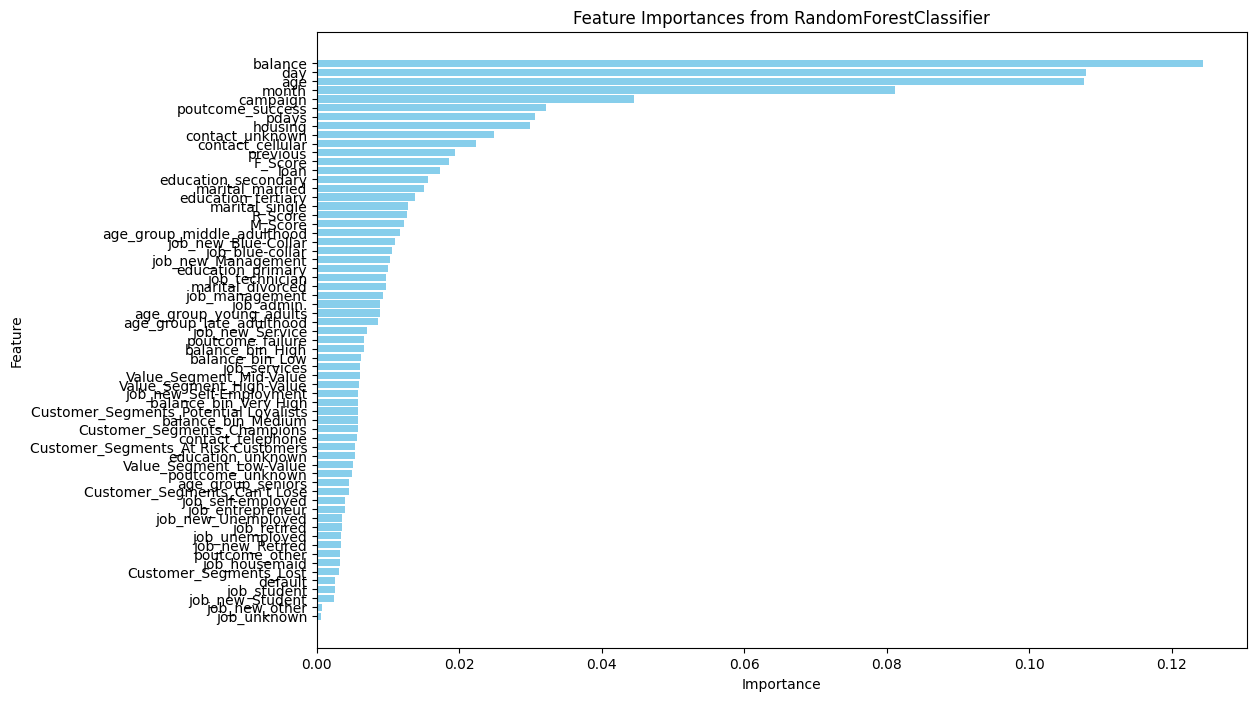

In [48]:
# Extract feature importances from the trained RandomForestClassifier
feature_importances = pipeline.named_steps['clf'].feature_importances_

# Get the feature names from the ColumnTransformer
ohe_features = pipeline.named_steps['prep'].transformers_[0][1].get_feature_names_out(to_ohe)
ordinal_features = to_ordinal
numeric_features = numeric

# Combine all feature names
all_features = list(ohe_features) + ordinal_features + numeric_features

# Create a DataFrame for feature importances
df_importances = pd.DataFrame({
    'Feature': all_features,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(12, 8))
plt.barh(df_importances['Feature'], df_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from RandomForestClassifier')
plt.gca().invert_yaxis()
plt.show()

In [49]:
included_feats_deposit = df_importances[df_importances['Importance'] > 0.01]['Feature'].values
included_feats_deposit

array(['balance', 'day', 'age', 'month', 'campaign', 'poutcome_success',
       'pdays', 'housing', 'contact_unknown', 'contact_cellular',
       'previous', 'F_Score', 'loan', 'education_secondary',
       'marital_married', 'education_tertiary', 'marital_single',
       'R_Score', 'M_Score', 'age_group_middle_adulthood',
       'job_new_Blue-Collar', 'job_blue-collar', 'job_new_Management'],
      dtype=object)

We do the same for feature duration, because it has the highest correlation with deposit but can't be used for the ML model.

In [50]:
to_drop = [ 'day_month', 'Recency', 'Frequency', 'Monetary', 
            'RFM_Score', "deposit"]
to_ordinal = ['marital', 'education', 'contact', 'age_group', 'job_new', 'Value_Segment', 'Customer_Segments', 'poutcome', 'month', 'day', 'balance_bin', 'job',  ]
numeric = ['default', 'housing', 'loan', 'previous', 'campaign', 'pdays', 'R_Score', 'F_Score', 'M_Score', 'balance', 'age',]

In [51]:
df = df_banking.copy()
df = df.drop(to_drop, axis=1)
X = df.drop('duration', axis=1)
y = df['duration']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [52]:
column_trans = ColumnTransformer(transformers=[
    ('ordinal_encoder', OrdinalEncoder(), to_ordinal),
    ('scaler', MinMaxScaler(), numeric)
])

In [53]:

clf = RandomForestRegressor(random_state=42, n_jobs=-1)

pipeline = Pipeline([('prep',column_trans),
                     ('clf', clf)])

pipeline.fit(X_train, y_train)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('ordinal_encoder',
                                                  OrdinalEncoder(),
                                                  ['marital', 'education',
                                                   'contact', 'age_group',
                                                   'job_new', 'Value_Segment',
                                                   'Customer_Segments',
                                                   'poutcome', 'month', 'day',
                                                   'balance_bin', 'job']),
                                                 ('scaler', MinMaxScaler(),
                                                  ['default', 'housing', 'loan',
                                                   'previous', 'campaign',
                                                   'pdays', 'R_Score',
                                                   'F_Score', 'M_Score',
                                                   'balance', 'age'])])),
                ('clf', RandomForestRegressor(n_jobs=-1, random_state=42))])

In [54]:
feat_list = []

total_importance = 0
# Print the name and gini importance of each feature
for feature in zip(X_train.columns, pipeline['clf'].feature_importances_):
    feat_list.append(feature)
    total_importance += feature[1]

included_feats_duration = []
# Print the name and gini importance of each feature
for feature in zip(X_train.columns, pipeline['clf'].feature_importances_):
    if feature[1] > .05:
        included_feats_duration.append(feature[0])


# create DataFrame using data
df_imp = pd.DataFrame(feat_list, columns =['FEATURE', 'IMPORTANCE']).\
                      sort_values(by='IMPORTANCE', ascending=False)
df_imp['CUMSUM'] = df_imp['IMPORTANCE'].cumsum()
included_feats_duration


['contact', 'day', 'campaign', 'job_new', 'Value_Segment', 'Customer_Segments']

combining the two lists

In [55]:
selected_features = list(set(included_feats_deposit) | set(included_feats_duration))
selected_features

['housing',
 'job_blue-collar',
 'age',
 'month',
 'age_group_middle_adulthood',
 'contact_cellular',
 'education_tertiary',
 'education_secondary',
 'R_Score',
 'M_Score',
 'poutcome_success',
 'previous',
 'F_Score',
 'job_new_Blue-Collar',
 'job_new',
 'loan',
 'Customer_Segments',
 'balance',
 'marital_single',
 'marital_married',
 'job_new_Management',
 'campaign',
 'contact',
 'day',
 'contact_unknown',
 'Value_Segment',
 'pdays']

## 3.2. Best model

In [56]:
selected_features = ['balance', 'day', 'age', 'month', 'campaign', 'poutcome_success',
    'pdays', 'housing', 'contact_unknown', 'contact_cellular',
    'previous', 'F_Score', 'loan', 'education_secondary',
    'marital_married', 'education_tertiary', 'marital_single',
    'R_Score', 'M_Score', 'age_group_middle_adulthood',
    'job_new_Blue-Collar', 'job_blue-collar', 'job_new_Management']

In [57]:
selected_features = ['balance', 'day', 'age', 'month', 'campaign', 'poutcome_success',
    'pdays', 'housing', 'contact_unknown', 'contact_cellular',
    'previous', 'loan', 'education_secondary',
    'marital_married', 'education_tertiary', 'marital_single',
    'job_new_Blue-Collar', 'job_blue-collar', 'job_new_Management']
numeric_selected = list(set(selected_features) & set(numeric))
ordinal_selected = list(set(selected_features) & set(to_ordinal))


df = df_banking.copy()
df = onehot_encode(df, to_ohe)
df = df[selected_features + ['deposit']].copy()
df.deposit = df.deposit.astype(int)
X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

scaler = MinMaxScaler()
X_train[numeric_selected] = scaler.fit_transform(X_train[numeric_selected])
X_test[numeric_selected] = scaler.transform(X_test[numeric_selected])

ordinalscaler = OrdinalEncoder()
X_train[ordinal_selected] = ordinalscaler.fit_transform(X_train[ordinal_selected])
X_test[ordinal_selected] = ordinalscaler.transform(X_test[ordinal_selected])


What do we need to do before:
- Scorer
- More weight to deposit=1

In [58]:
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1, average="weighted")

rfc = BalancedRandomForestClassifier(random_state=42, n_jobs=-1, class_weight={0:1,1:10}, max_depth=2, bootstrap=True, sampling_strategy="not majority", replacement=False)
rfc.fit(X_train, y_train)
y_train_predict = rfc.predict(X_train)
y_test_predict = rfc.predict(X_test)
print("Accuracy")
print("Train Accuracy:", accuracy_score(y_train, y_train_predict))
print("Test Accuracy:", accuracy_score(y_test, y_test_predict))
print("fbeta")
print(f"fbeta scorer train: {f2_scorer(rfc, X_train, y_train):.2f}")
print(f"fbeta scorer test: {f2_scorer(rfc, X_test, y_test):.2f}")
print(classification_report(y_train, y_train_predict))
print(confusion_matrix(y_train, y_train_predict))
print(classification_report(y_test, y_test_predict))
print(confusion_matrix(y_test, y_test_predict))

Accuracy
Train Accuracy: 0.38765127816222705
Test Accuracy: 0.3897817752875258
fbeta
fbeta scorer train: 0.38
fbeta scorer test: 0.38
              precision    recall  f1-score   support

           0       0.96      0.32      0.48     27945
           1       0.15      0.90      0.26      3702

    accuracy                           0.39     31647
   macro avg       0.55      0.61      0.37     31647
weighted avg       0.87      0.39      0.45     31647

[[ 8937 19008]
 [  371  3331]]
              precision    recall  f1-score   support

           0       0.96      0.32      0.48     11977
           1       0.15      0.90      0.26      1587

    accuracy                           0.39     13564
   macro avg       0.55      0.61      0.37     13564
weighted avg       0.87      0.39      0.46     13564

[[3860 8117]
 [ 160 1427]]


## 3.3. Hyperparameter Tuning

In [59]:

numeric_selected = list(set(selected_features) & set(numeric))
ordinal_selected = list(set(selected_features) & set(to_ordinal))


In [60]:
selected_features = ['balance', 'day', 'age', 'month', 'campaign', 'poutcome_success',
    'pdays', 'housing', 'contact_unknown', 'contact_cellular',
    'previous', 'loan', 'education_secondary',
    'marital_married', 'education_tertiary', 'marital_single',
    'job_new_Blue-Collar', 'job_blue-collar', 'job_new_Management']

df = df_banking.copy()
df = onehot_encode(df, to_ohe)
df = df[selected_features + ['deposit']].copy()
df.deposit = df.deposit.astype(int)
X = df.drop('deposit', axis=1)
y = df['deposit']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [61]:

# Define the precision scorer
f2_scorer = make_scorer(fbeta_score, beta=2, pos_label=1, average="weighted")

# Define the parameter grid for RandomizedSearchCV
param_distributions = {
    'rfc__n_estimators': (None, 50, 100, 150, 200, 250, 300),
    'rfc__max_depth': randint(2, 8),
    'rfc__min_samples_split': (None, 2, 4, 6, 8, 10),
    'rfc__min_samples_leaf': (None, 2, 4, 6, 8, 10),
    "rfc__bootstrap": [True, False],
    "rfc__replacement": [True, False],
    "rfc__class_weight": [{0: 1, 1: 10}, {0: 1, 1: 15}, {0: 1, 1: 20}, {0: 1, 1: 25}, {0: 1, 1: 30}, "balance"],
}

# Define the transformer
column_trans = ColumnTransformer(transformers=[
    ('scaler', MinMaxScaler(), numeric_selected),
    ('ordinal', OrdinalEncoder(), ordinal_selected)
])

# Define the pipeline
pipeline = Pipeline([
    ('prep', column_trans),
    ('rfc', BalancedRandomForestClassifier(random_state=42, sampling_strategy="not majority"))
])

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_distributions,
    n_iter=200,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring=f2_scorer
)

# Fit the RandomizedSearchCV
random_search.fit(X_train, y_train)

# Predictions on training and test sets
y_train_pred = random_search.predict(X_train)
y_test_pred = random_search.predict(X_test)
recall_train = f2_scorer(random_search, X_train, y_train)
recall_test = f2_scorer(random_search, X_test, y_test)
# Print the best parameters and the best score
print(f"Best parameters: {random_search.best_params_}")
print(f"f2-score cat1 train: {recall_train}")
print(f"f2-score cat1 test: {recall_test}")
# Classification reports
print("Training Set Classification Report:")
print(classification_report(y_train, y_train_pred))
print(confusion_matrix(y_train, y_train_pred))
print("Test Set Classification Report:")
print(classification_report(y_test, y_test_pred))
print(confusion_matrix(y_test, y_test_pred))


Fitting 3 folds for each of 200 candidates, totalling 600 fits


d:\Data Science Projekte\241021_Customer_Segementation\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning:


315 fits failed out of a total of 600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
72 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Data Science Projekte\241021_Customer_Segementation\.conda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Data Science Projekte\241021_Customer_Segementation\.conda\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  Fil

Best parameters: {'rfc__bootstrap': True, 'rfc__class_weight': {0: 1, 1: 10}, 'rfc__max_depth': 7, 'rfc__min_samples_leaf': 8, 'rfc__min_samples_split': 8, 'rfc__n_estimators': 50, 'rfc__replacement': False}
f2-score cat1 train: 0.7118598410375433
f2-score cat1 test: 0.7077209647497412
Training Set Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.70      0.81     27945
           1       0.24      0.69      0.35      3702

    accuracy                           0.70     31647
   macro avg       0.59      0.70      0.58     31647
weighted avg       0.86      0.70      0.75     31647

[[19619  8326]
 [ 1140  2562]]
Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.70      0.80     11977
           1       0.23      0.67      0.34      1587

    accuracy                           0.70     13564
   macro avg       0.59      0.69      0.57     13564
weighted avg   

The baseline got beat with a f2_score of 0.70. 